In [ ]:
import os
import cv2
import math
import joblib
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from tensorflow.keras.utils import plot_model

2024-04-01 13:57:05.269131: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 13:57:05.269252: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 13:57:05.433648: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
DATA_PATH = "/kaggle/input/fyp-dataset/ck/ck/"
TOP_EMOTIONS = ["Angry", "Fear", "Happy", "Sadness", "Surprise"]

# Define constants
TRAIN_SIZE = 0.80
INPUT_SHAPE = (71, 71, 3) # input size must 71 x 71
NUM_CLASSES = len(TOP_EMOTIONS)
BATCH_SIZE = 32
EPOCHS = 100

In [ ]:
total_images = 0
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        count = 0
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            count += 1
        print(f"{dir_} has {count} number of images")
        total_images += count

print(f"\ntotal images are {total_images}")

Surprise has 249 number of images
Fear has 75 number of images
Angry has 135 number of images
Sadness has 84 number of images
Happy has 207 number of images

total images are 750


In [ ]:
img_arr = []
img_label = []
label_to_text = {}
label = 0

for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img = cv2.imread(DATA_PATH + dir_ + "/" + f)
            img = cv2.resize(img, (71, 71))

            # Convert image to RGB format if it's grayscale
            if img.shape[-1] == 1:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            img_arr.append(img)
            img_label.append(label)
        print(f"loaded {dir_} images to numpy arrays...")
        label_to_text[label] = dir_
        label += 1

img_arr = np.array(img_arr)
img_label = np.array(img_label)
img_label = OneHotEncoder(sparse=False).fit_transform(img_label.reshape(-1, 1))

img_arr.shape, img_label.shape, label_to_text

loaded Surprise images to numpy arrays...
loaded Fear images to numpy arrays...
loaded Angry images to numpy arrays...
loaded Sadness images to numpy arrays...
loaded Happy images to numpy arrays...


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((750, 71, 71, 3),
 (750, 5),
 {0: 'Surprise', 1: 'Fear', 2: 'Angry', 3: 'Sadness', 4: 'Happy'})

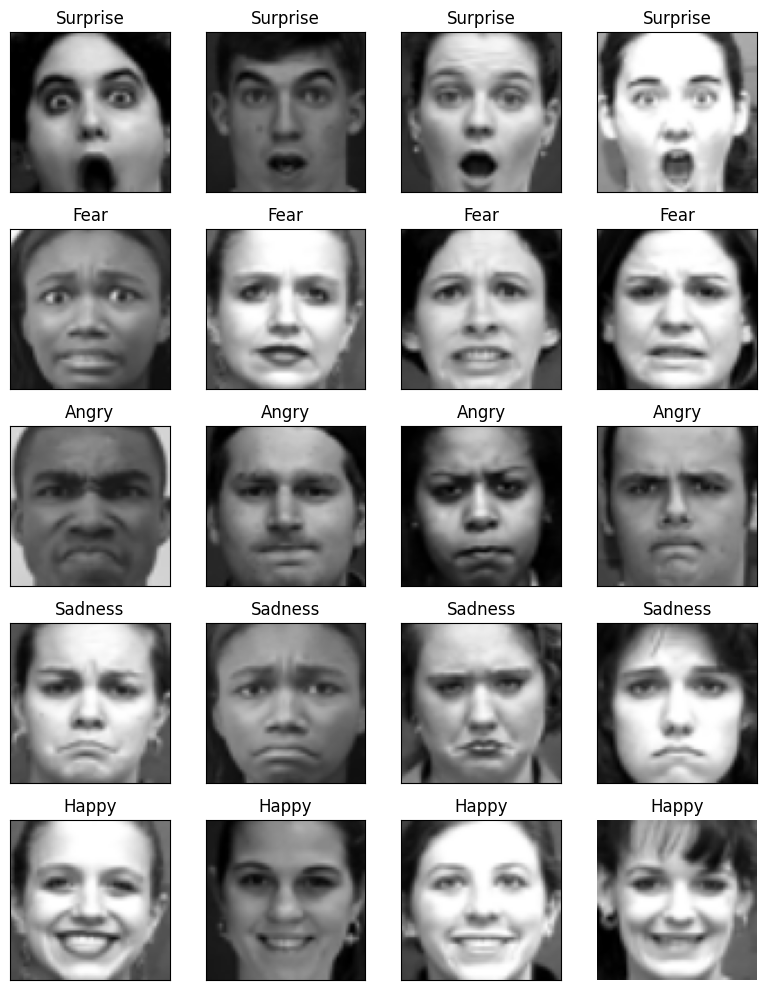

In [ ]:
num_emotions = len(TOP_EMOTIONS)
num_cols = 4
fig, axes = pyplot.subplots(num_emotions, num_cols, figsize=(num_cols*2, num_emotions*2))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:, k] == 1)[0], size=num_cols, replace=False)
    sample_images = img_arr[sample_indices]

    for i, img in enumerate(sample_images):
        ax = axes[idx, i]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img), pyplot.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])

    idx += 1

pyplot.tight_layout()
pyplot.show()

In [ ]:
img_arr = img_arr / 255.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=TRAIN_SIZE, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((600, 71, 71, 3), (150, 71, 71, 3), (600, 5), (150, 5))

In [ ]:
# Define a custom callback for early stopping based on validation accuracy
class CustomEarlyStopping(Callback):
    def __init__(self, monitor='val_accuracy', patience=10, restore_best_weights=True):
        super(CustomEarlyStopping, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best = -np.Inf  # Initialize best to negative infinity
        self.best_epoch = 0
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        current_val_acc = logs.get(self.monitor)
        if current_val_acc > self.best:
            self.best = current_val_acc
            self.best_epoch = epoch
            self.best_weights = self.model.get_weights()  # Save the best weights
        elif epoch - self.best_epoch >= self.patience:
            print(f"Epoch {epoch}: Early stopping due to no improvement in {self.patience} epochs.")
            self.model.stop_training = True
            if self.restore_best_weights and self.best_weights is not None:
                print(f"Restoring best weights from epoch {self.best_epoch}.")
                self.model.set_weights(self.best_weights)

In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    horizontal_flip=True,
)

# Fit the data generator on training data
train_datagen.fit(X_train)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# https://www.tensorflow.org/guide/keras/transfer_learning#train_the_top_layer

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Freeze layers in the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Build model on top of pre-trained model
inputs = Input(shape=INPUT_SHAPE)

# Add convolutional layers, pooling layers, etc., to build your model architecture
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 71, 71, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 69, 69, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 34, 34, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,117,317 (8.08 MB)

 Trainable params: 2,117,317 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.1,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0005,
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

In [ ]:
custom_early_stopping = CustomEarlyStopping(patience=25)

# Train the top layer
history_top_layer = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    steps_per_epoch=int(len(X_train) / BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=[lr_scheduler, custom_early_stopping],
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 5/18 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2635 - loss: 1.6262

I0000 00:00:1711979848.923393     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711979848.941872     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/18 ━━━━━━━━━━━━━━━━━━━━ 2s 407ms/step - accuracy: 0.2888 - loss: 1.5958

W0000 00:00:1711979854.723715     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 391ms/step - accuracy: 0.3151 - loss: 1.5748 - val_accuracy: 0.3933 - val_loss: 1.4300 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4375 - loss: 1.2605 - val_accuracy: 0.6000 - val_loss: 1.3825 - learning_rate: 0.0010
Epoch 3/100


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5755 - loss: 1.3207 - val_accuracy: 0.6400 - val_loss: 0.9732 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5312 - loss: 1.1155 - val_accuracy: 0.6467 - val_loss: 0.9167 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6944 - loss: 0.8885 - val_accuracy: 0.7733 - val_loss: 0.6178 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7188 - loss: 0.7491 - val_accuracy: 0.7800 - val_loss: 0.5857 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7402 - loss: 0.7340 - val_accuracy: 0.8333 - val_loss: 0.5012 - learning_rate: 0.0010
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7500 - loss: 0.6266 - val_accuracy: 0.8600 - val_loss: 0.4582 - learning_rate: 0.0010
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8134 - loss: 0.5501 - val_accuracy: 0

In [ ]:
# Create history dataframe for the top layer training
history_top_layer_df = pd.DataFrame(history_top_layer.history)
history_top_layer_df

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.380282,1.515058,0.393333,1.430045,1.000000e-03
1,0.437500,1.260539,0.600000,1.382492,1.000000e-03
2,0.595070,1.250238,0.640000,0.973222,1.000000e-03
3,0.531250,1.115457,0.646667,0.916669,1.000000e-03
4,0.698944,0.851398,0.773333,0.617817,1.000000e-03
5,0.718750,0.749066,0.780000,0.585671,1.000000e-03
6,0.751761,0.700560,0.833333,0.501191,1.000000e-03
7,0.750000,0.626603,0.860000,0.458210,1.000000e-03
8,0.808099,0.565604,0.820000,0.492583,1.000000e-03
9,0.781250,0.635921,0.813333,0.507805,1.000000e-03


In [ ]:
# Fine-tuning the entire model
for layer in base_model.layers:
    layer.trainable = True

# Compile the model again
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model after fine-tuning
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 71, 71, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 69, 69, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 34, 34, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,117,317 (8.08 MB)

 Trainable params: 2,117,317 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the entire model end-to-end with a low learning rate
history_fine_tuning = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    steps_per_epoch=int(len(X_train) / BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=[lr_scheduler, custom_early_stopping],
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 5/18 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9022 - loss: 0.3096

W0000 00:00:1711979887.936807     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9161 - loss: 0.2718

W0000 00:00:1711979892.179864     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 265ms/step - accuracy: 0.9170 - loss: 0.2695 - val_accuracy: 0.9333 - val_loss: 0.2255 - learning_rate: 1.0000e-05
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9688 - loss: 0.2475 - val_accuracy: 0.9333 - val_loss: 0.2255 - learning_rate: 1.0000e-05
Epoch 3/100


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9252 - loss: 0.2349 - val_accuracy: 0.9333 - val_loss: 0.2243 - learning_rate: 1.0000e-05
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9375 - loss: 0.1077 - val_accuracy: 0.9333 - val_loss: 0.2242 - learning_rate: 1.0000e-05
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9443 - loss: 0.1736 - val_accuracy: 0.9400 - val_loss: 0.2246 - learning_rate: 1.0000e-05
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9062 - loss: 0.2028 - val_accuracy: 0.9400 - val_loss: 0.2246 - learning_rate: 1.0000e-05
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8979 - loss: 0.2498 - val_accuracy: 0.9400 - val_loss: 0.2238 - learning_rate: 1.0000e-05
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9062 - loss: 0.2794 - val_accuracy: 0.9400 - val_loss: 0.2239 - learning_rate: 1.0000e-05
Epoch 9/100
12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9500 - loss: 

In [ ]:
# Create history dataframe for fine-tuning
history_fine_tuning_df = pd.DataFrame(history_fine_tuning.history)
history_fine_tuning_df

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.933099,0.226306,0.933333,0.225494,1.000000e-05
1,0.968750,0.247522,0.933333,0.225475,1.000000e-05
2,0.924296,0.237208,0.933333,0.224281,1.000000e-05
3,0.937500,0.107703,0.933333,0.224176,1.000000e-05
4,0.934859,0.184017,0.940000,0.224604,1.000000e-05
5,0.906250,0.202831,0.940000,0.224624,1.000000e-05
6,0.931338,0.195976,0.940000,0.223751,1.000000e-05
7,0.906250,0.279364,0.940000,0.223928,1.000000e-05
8,0.926056,0.221936,0.933333,0.225912,1.000000e-05
9,0.937500,0.296564,0.933333,0.225932,1.000000e-06


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

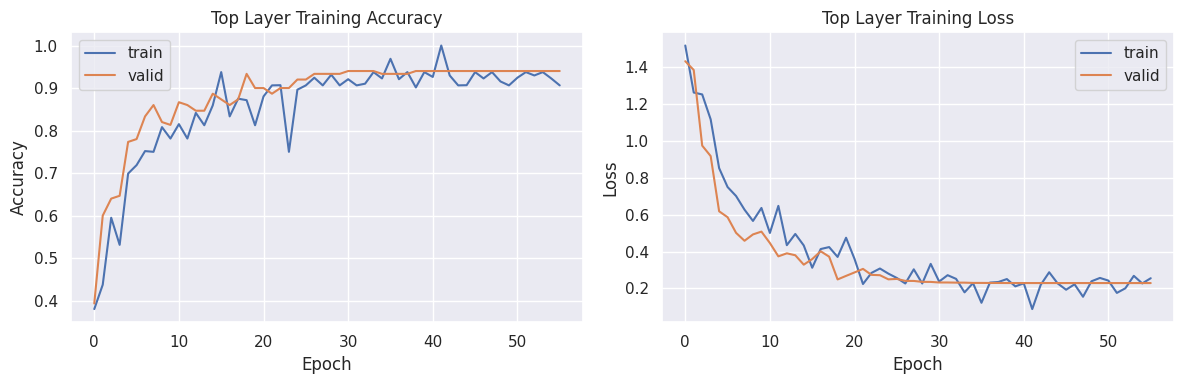

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

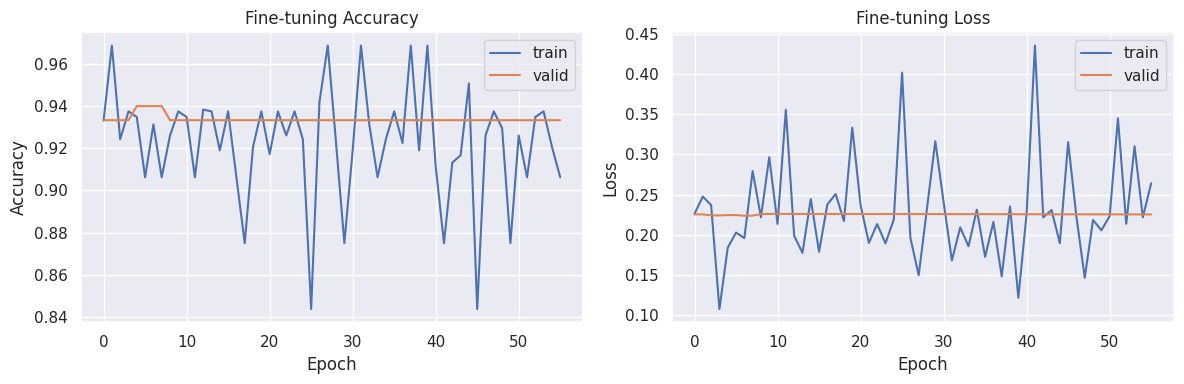

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize training history for the top layer training
sns.set()
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history_top_layer_df.index, y=history_top_layer_df['accuracy'], label='train')
sns.lineplot(x=history_top_layer_df.index, y=history_top_layer_df['val_accuracy'], label='valid')
plt.title('Top Layer Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history_top_layer_df.index, y=history_top_layer_df['loss'], label='train')
sns.lineplot(x=history_top_layer_df.index, y=history_top_layer_df['val_loss'], label='valid')
plt.title('Top Layer Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

plt.show()

# Visualize training history for fine-tuning
sns.set()
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history_fine_tuning_df.index, y=history_fine_tuning_df['accuracy'], label='train')
sns.lineplot(x=history_fine_tuning_df.index, y=history_fine_tuning_df['val_accuracy'], label='valid')
plt.title('Fine-tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history_fine_tuning_df.index, y=history_fine_tuning_df['loss'], label='train')
sns.lineplot(x=history_fine_tuning_df.index, y=history_fine_tuning_df['val_loss'], label='valid')
plt.title('Fine-tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

plt.show()

19/19 - 0s - 23ms/step - accuracy: 0.9633 - loss: 0.1297

train Accuracy: 0.9633333086967468
5/5 - 0s - 6ms/step - accuracy: 0.9400 - loss: 0.2325

Test Accuracy: 0.9399999976158142
1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step

W0000 00:00:1711979923.616279     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

Classification Report:
               precision    recall  f1-score   support

       Angry       1.00      0.98      0.99        50
        Fear       0.87      0.87      0.87        15
       Happy       0.87      0.96      0.91        27
     Sadness       0.92      0.71      0.80        17
    Surprise       0.95      1.00      0.98        41

    accuracy                           0.94       150
   macro avg       0.92      0.90      0.91       150
weighted avg       0.94      0.94      0.94       150



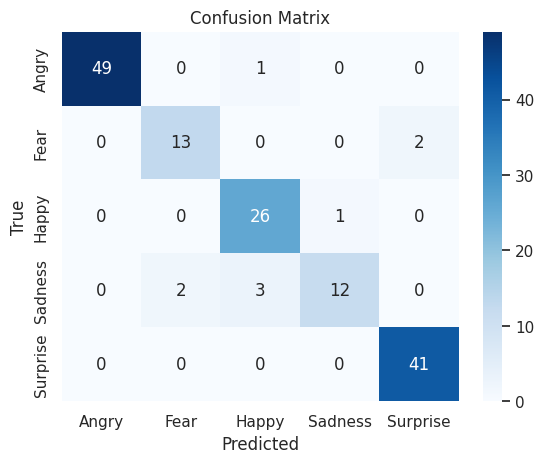

In [ ]:
# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=2)
print(f"\ntrain Accuracy: {train_acc}")

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest Accuracy: {test_acc}")

# Predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Classification Report
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels, target_names=TOP_EMOTIONS))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=TOP_EMOTIONS, yticklabels=TOP_EMOTIONS)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
label_to_text

{0: 'Surprise', 1: 'Fear', 2: 'Angry', 3: 'Sadness', 4: 'Happy'}

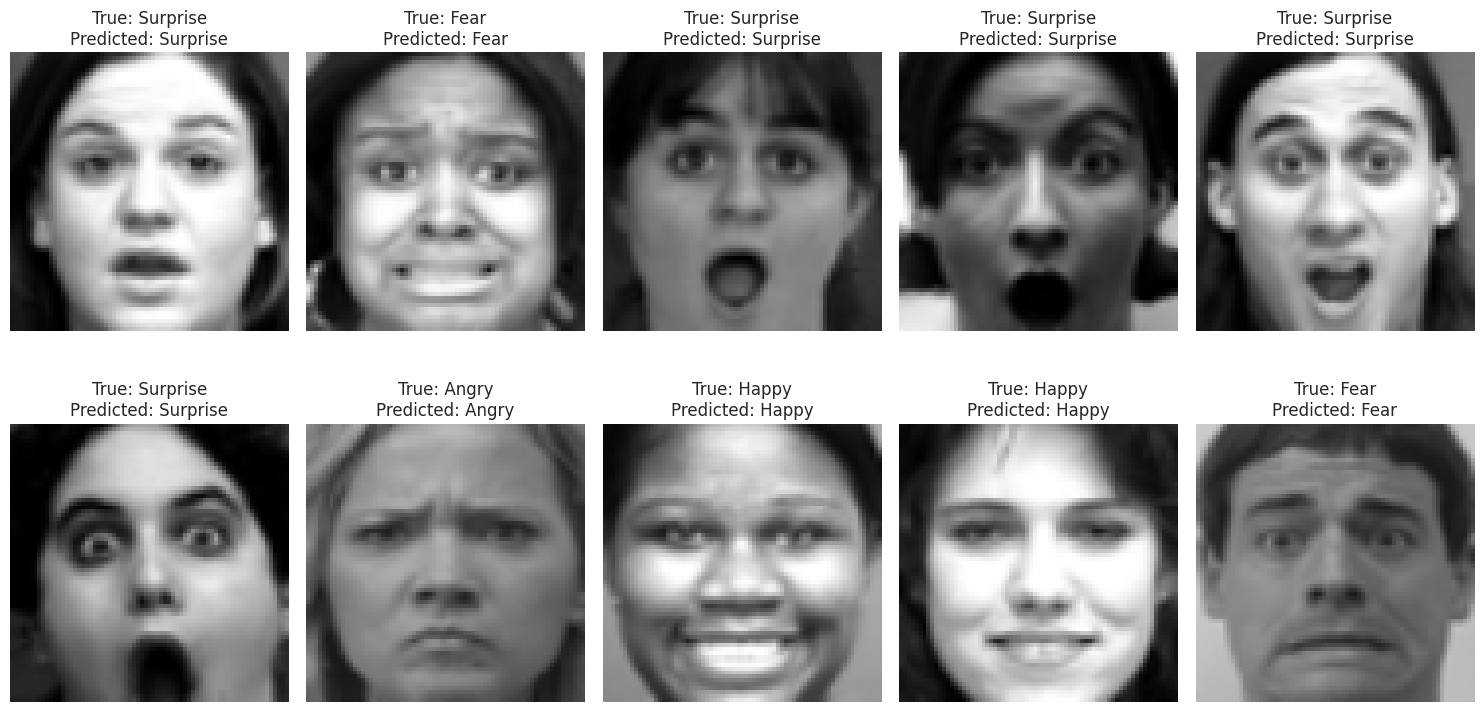

In [ ]:
import random

# Visualize some predictions
num_images_to_visualize = 10
random_indices = np.random.choice(len(X_test), size=num_images_to_visualize, replace=False)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.title(f"True: {label_to_text[true_labels[idx]]}\nPredicted: {label_to_text[predicted_labels[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()